MSSP 607 Case Study Report Assignment 1

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

In [13]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/MSSP607/e.Data/data_academic_performance.xlsx'
df = pd.read_excel(path, sheet_name='SABER11_SABERPRO')
print(df.shape)
df.head(3)
list(df.columns)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(12411, 45)


['COD_S11',
 'GENDER',
 'EDU_FATHER',
 'EDU_MOTHER',
 'OCC_FATHER',
 'OCC_MOTHER',
 'STRATUM',
 'SISBEN',
 'PEOPLE_HOUSE',
 'Unnamed: 9',
 'INTERNET',
 'TV',
 'COMPUTER',
 'WASHING_MCH',
 'MIC_OVEN',
 'CAR',
 'DVD',
 'FRESH',
 'PHONE',
 'MOBILE',
 'REVENUE',
 'JOB',
 'SCHOOL_NAME',
 'SCHOOL_NAT',
 'SCHOOL_TYPE',
 'MAT_S11',
 'CR_S11',
 'CC_S11',
 'BIO_S11',
 'ENG_S11',
 'Cod_SPro',
 'UNIVERSITY',
 'ACADEMIC_PROGRAM',
 'QR_PRO',
 'CR_PRO',
 'CC_PRO',
 'ENG_PRO',
 'WC_PRO',
 'FEP_PRO',
 'G_SC',
 'PERCENTILE',
 '2ND_DECILE',
 'QUARTILE',
 'SEL',
 'SEL_IHE']

In [15]:
cols = ['PERCENTILE','EDU_FATHER','EDU_MOTHER','STRATUM','GENDER']
data = df[cols].copy()
print(data.shape)
print(data.head(3))

(12411, 5)
   PERCENTILE                         EDU_FATHER  \
0          91  Incomplete Professional Education   
1          92                 Complete Secundary   
2           7                           Not sure   

                         EDU_MOTHER    STRATUM GENDER  
0  Complete technique or technology  Stratum 4      F  
1   Complete professional education  Stratum 5      F  
2                          Not sure  Stratum 2      M  


# Education
not sure: consider as na, 0 or Niguono: uneducated

Does parental education influence outcomes, and if so, how much?

In [42]:
print(df['EDU_FATHER'].value_counts(dropna=False))
edu_order = [
    'Ninguno','0',
    'Incomplete primary', 'Complete primary',
    'Incomplete Secundary', 'Complete Secundary',
    'Incomplete technical or technological', 'Complete technique or technology',
    'Incomplete Professional Education', 'Complete professional education',
    'Postgraduate education'
]
unknown_labels = {'Not sure'}

def to_ordered_score(series, order, unknown=()):
    s = series.astype(str).str.strip()
    s = s.where(~s.isin(unknown), np.nan)
    cat = pd.Categorical(s, categories=order, ordered=True)
    scores = pd.Series(cat.codes, index=series.index).replace(-1, np.nan)
    return scores

data['EDU_FATHER_SCORE'] = to_ordered_score(data['EDU_FATHER'], edu_order, unknown_labels)
data['EDU_MOTHER_SCORE'] = to_ordered_score(data['EDU_MOTHER'], edu_order, unknown_labels)
data['PARENT_ED_INDEX'] = data[['EDU_FATHER_SCORE','EDU_MOTHER_SCORE']].mean(axis=1, skipna=True)

EDU_FATHER
Complete professional education          3016
Complete Secundary                       2843
Complete technique or technology         1194
Incomplete Secundary                     1091
Postgraduate education                   1085
Complete primary                          824
Incomplete primary                        735
Incomplete Professional Education         425
Not sure                                  407
0                                         391
Incomplete technical or technological     277
Ninguno                                   123
Name: count, dtype: int64


In [19]:
edu_mean = data.groupby('PARENT_ED_INDEX')['PERCENTILE'].mean()
data.groupby('PARENT_ED_INDEX')['PERCENTILE'].mean()

,PERCENTILE
PARENT_ED_INDEX,
0.0,49.800000
1.0,60.663768
1.5,61.535354
2.0,58.867987
2.5,63.095238
3.0,59.443277
3.5,60.719128
4.0,60.350345
4.5,61.902290


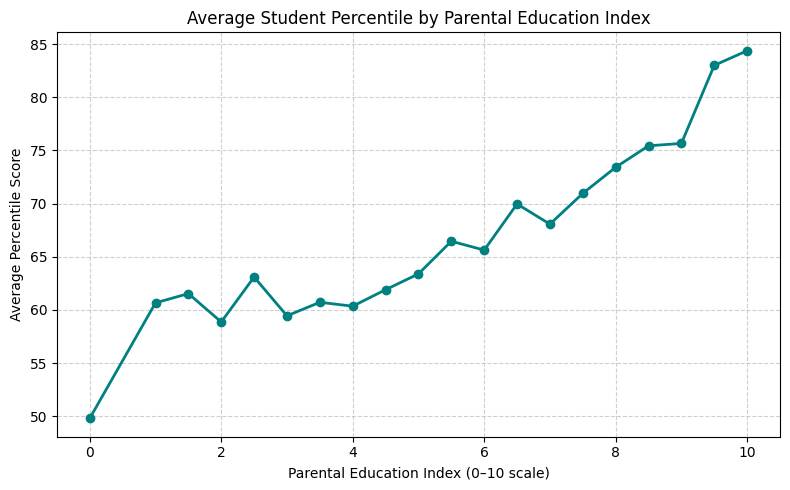

In [20]:
plt.figure(figsize=(8,5))
plt.plot(edu_mean.index, edu_mean.values, marker='o', linewidth=2, color='teal')
plt.title("Average Student Percentile by Parental Education Index")
plt.xlabel("Parental Education Index (0–10 scale)")
plt.ylabel("Average Percentile Score")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [24]:
X = sm.add_constant(data["PARENT_ED_INDEX"].dropna())
y = data.loc[X.index, "PERCENTILE"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             PERCENTILE   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     911.4
Date:                Tue, 04 Nov 2025   Prob (F-statistic):          3.34e-193
Time:                        20:19:59   Log-Likelihood:                -56976.
No. Observations:               12293   AIC:                         1.140e+05
Df Residuals:                   12291   BIC:                         1.140e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              50.8375      0.627     

# Stratum
Which groups/stratum perform best?

Are there differences between groups/stratums?

In [27]:
df['STRATUM_NUM'] = df['STRATUM'].str.extract(r'(\d+)').astype(float)
df['STRATUM_NUM'].unique()

array([ 4.,  5.,  2.,  6.,  3.,  1., nan])

In [28]:
strat_mean = df.groupby('STRATUM_NUM')['PERCENTILE'].agg(['mean','std','count'])
print(strat_mean)

                  mean        std  count
STRATUM_NUM                             
1.0          56.970743  26.961988   1709
2.0          63.669149  26.358737   4029
3.0          70.151545  24.335949   4045
4.0          78.427123  21.619470   1578
5.0          83.203791  19.370338    633
6.0          85.831266  18.560009    403


/tmp/ipython-input-2753826834.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='STRATUM_NUM', y='PERCENTILE', data=df, palette='viridis', showfliers=False)
/tmp/ipython-input-2753826834.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='STRATUM_NUM', y='PERCENTILE', data=df, color='black', markers='o', ci=None)


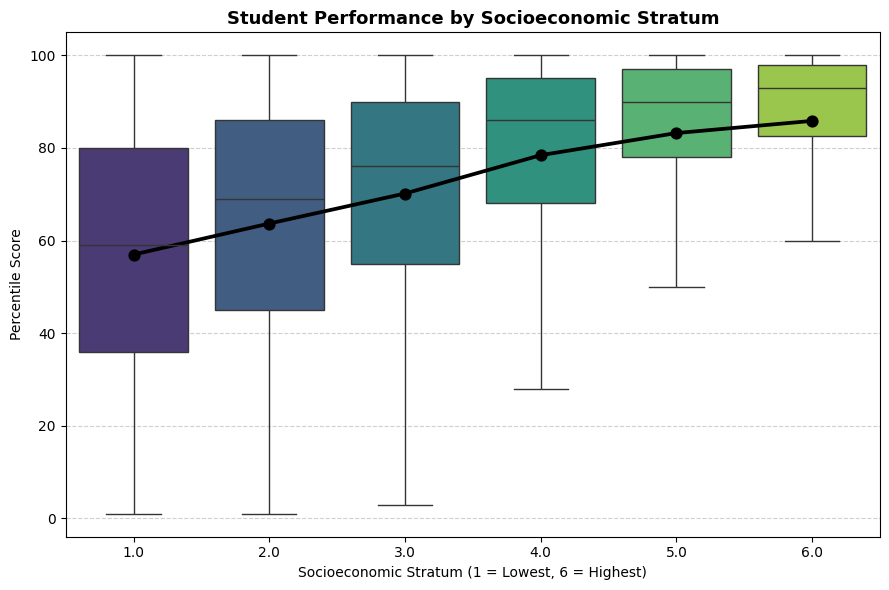

In [32]:
plt.figure(figsize=(9,6))
sns.boxplot(x='STRATUM_NUM', y='PERCENTILE', data=df, palette='viridis', showfliers=False)
sns.pointplot(x='STRATUM_NUM', y='PERCENTILE', data=df, color='black', markers='o', ci=None)

plt.title('Student Performance by Socioeconomic Stratum', fontsize=13, weight='bold')
plt.xlabel('Socioeconomic Stratum (1 = Lowest, 6 = Highest)')
plt.ylabel('Percentile Score')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Gender
How does each gender perform in the global assessment?

In [33]:
gender_stats = df.groupby('GENDER')['PERCENTILE'].agg(['mean','std','count'])
print(gender_stats)

             mean        std  count
GENDER                             
F       67.133254  25.801336   5043
M       69.345277  25.876128   7368


/tmp/ipython-input-959312825.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='GENDER', y='PERCENTILE', data=df, palette='coolwarm')


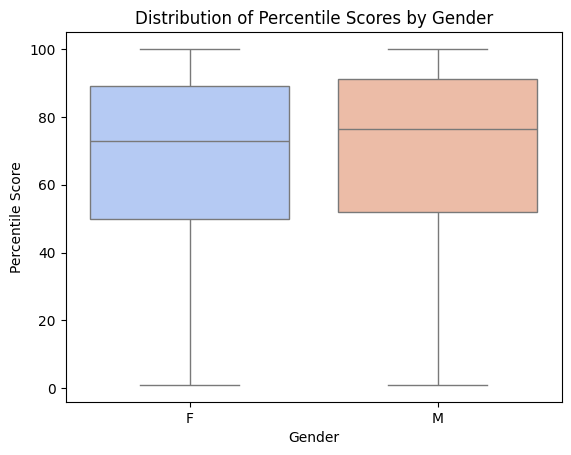

In [34]:
sns.boxplot(x='GENDER', y='PERCENTILE', data=df, palette='coolwarm')
plt.title('Distribution of Percentile Scores by Gender')
plt.xlabel('Gender')
plt.ylabel('Percentile Score')
plt.show()

In [35]:
from scipy import stats
male_scores = df.loc[df['GENDER']=='M','PERCENTILE'].dropna()
female_scores = df.loc[df['GENDER']=='F','PERCENTILE'].dropna()

t_stat, p_val = stats.ttest_ind(male_scores, female_scores, equal_var=False)
print(f"T-statistic: {t_stat:.3f},  p-value: {p_val:.4f}")

T-statistic: 4.685,  p-value: 0.0000


# Education + Stratum + Gender

In [40]:
ols_data = data[['PERCENTILE', 'PARENT_ED_INDEX', 'STRATUM', 'GENDER']].dropna().copy()
ols_data['STRATUM_NUM'] = ols_data['STRATUM'].str.extract(r'(\d+)').astype(float)
ols_data['GENDER_M'] = (ols_data['GENDER'] == 'M').astype(int)
ols_data = ols_data.replace([np.inf, -np.inf], np.nan).dropna(subset=['PERCENTILE','PARENT_ED_INDEX','STRATUM_NUM','GENDER_M'])

In [41]:
X = ols_data[['PARENT_ED_INDEX', 'STRATUM_NUM', 'GENDER_M']]
y = ols_data['PERCENTILE']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             PERCENTILE   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     498.5
Date:                Tue, 04 Nov 2025   Prob (F-statistic):          1.10e-305
Time:                        20:36:23   Log-Likelihood:                -56643.
No. Observations:               12279   AIC:                         1.133e+05
Df Residuals:                   12275   BIC:                         1.133e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              43.8600      0.714     